# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.


In [1]:
# Importing libraries
import os
import boto3
import sagemaker

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from utils import *

%matplotlib inline

In [2]:
# sagemaker session, role
session = sagemaker.Session()
s3_client = boto3.client('s3')

In [4]:
azdias, customers = read_s3_files(['azdias.pkl', 'customers.pkl'], s3_client)
print('Azdias:', azdias.shape)
print('Customers:', customers.shape)

Azdias: (891221, 388)
Customers: (191652, 388)


In [5]:
azdias_lnr = azdias['LNR'].copy()
azdias.drop('LNR', axis=1, inplace=True)
customers_lnr = customers['LNR'].copy()
customers.drop('LNR', axis=1, inplace=True)


## Pricipal Component Analysis
Before training our machine learning model, we'll reduce the demension of our data for which we'll use **Incremental Principal Component Analysis.** Increamental PCA requires to split data into smaller batches, which are fed to IPCA one at a time.

In [6]:
pca = PCA()
pca.fit(azdias)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [7]:
pca.explained_variance_ratio_

array([7.84993237e-02, 4.81501876e-02, 4.45038665e-02, 3.58805671e-02,
       2.18462939e-02, 1.93497285e-02, 1.69448687e-02, 1.60126196e-02,
       1.56756823e-02, 1.37983890e-02, 1.27046218e-02, 1.17192844e-02,
       1.13172468e-02, 1.02775680e-02, 9.98351095e-03, 9.21138245e-03,
       8.94859292e-03, 8.46611517e-03, 8.33106321e-03, 7.94594561e-03,
       7.75500828e-03, 7.55734079e-03, 7.27342427e-03, 7.05286117e-03,
       6.95659409e-03, 6.65502620e-03, 6.65340183e-03, 6.10261563e-03,
       5.80860532e-03, 5.71283512e-03, 5.44179470e-03, 5.13940484e-03,
       5.09504918e-03, 5.06076521e-03, 4.90343557e-03, 4.85695975e-03,
       4.64241900e-03, 4.61710424e-03, 4.52689177e-03, 4.47729260e-03,
       4.35132582e-03, 4.25582236e-03, 4.15639352e-03, 4.08187570e-03,
       4.06018189e-03, 4.03340366e-03, 3.90871442e-03, 3.78800456e-03,
       3.68561256e-03, 3.68281648e-03, 3.65040187e-03, 3.57122803e-03,
       3.52244757e-03, 3.50830626e-03, 3.46039271e-03, 3.42622507e-03,
      

----

### PCA Model Attributes

Three types of model attributes are contained within the PCA model.

    mean: The mean that was subtracted from a component in order to center it.
    v: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
    s: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

We are only interested in v and s.

From s, we can get an approximation of the data variance that is covered in the first n principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for all components:
$$\begin{equation*} \frac{\sum_{n}^{ } s_n^2}{\sum s^2} \end{equation*}$$

From v, we can learn more about the combinations of original features that make up each principal component.


In [8]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [9]:
def explained_variance(s, n_top_components):
    """Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.
    """
    start_idx = N_COMPONENTS - n_top_components
    top_principal_components = s.iloc[start_idx:, :]
    
    variance = np.sum(np.square(top_principal_components)) / np.sum(np.square(s))
    
    return variance[0]

In [10]:
exp_variance = []

# calculate the explained variance
for n in range(1, 354):
    evar = explained_variance(s, n)
    exp_variance.append(evar)
    if n % 50 == 0:
        print('Explained variance for top {} is: {}'.format(n, evar))


Explained variance for top 50 is: 0.606728732585907
Explained variance for top 100 is: 0.7550870776176453
Explained variance for top 150 is: 0.8589470386505127
Explained variance for top 200 is: 0.9290238618850708
Explained variance for top 250 is: 0.9682955145835876
Explained variance for top 300 is: 0.9900360703468323
Explained variance for top 350 is: 0.9999566078186035


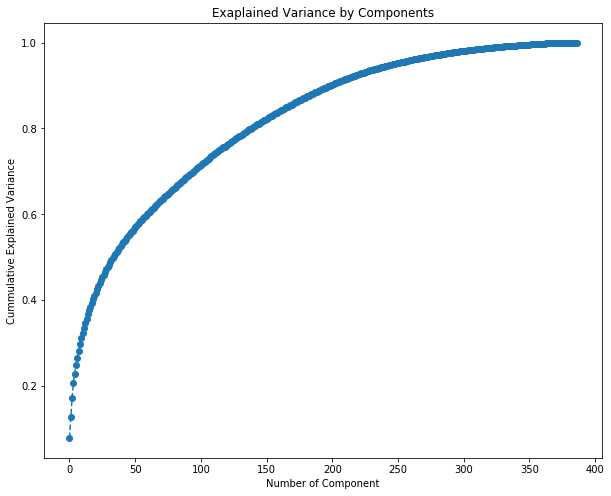

In [8]:
plt.figure(figsize=(10,8))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='o',linestyle='--')
plt.title("Exaplained Variance by Components")
plt.xlabel("Number of Component")
plt.ylabel("Cummulative Explained Variance")
plt.show()

We can notice **top 150 components** are able to explain 85% of the variance in our data. 80% is generally accepted threshold for data variance.

In [14]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS - component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights'] = comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax = plt.subplots(figsize=(10,6))
    ax = sns.barplot(data=sorted_weight_data, 
                    x="weights", 
                    y="features", 
                    palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

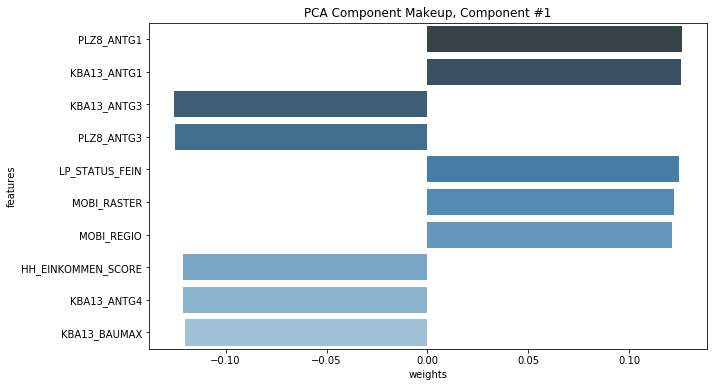

In [16]:
# display makeup of first component
num = 1
display_component(v, azdias.columns.values, component_num=num, n_weights=10)

In [18]:
del pca_model_params
del s
del v
del exp_variance

## Reducing components

In [13]:
def reduce_component(df, n=180):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [14]:
azdias_transformed = reduce_component(azdias)
print(azdias_transformed.shape)
customers_transformed = reduce_component(customers)
print(customers_transformed.shape)

0.8692946890991515
(891221, 180)
0.8703916942596288
(191652, 180)


At n = 150:
- Explained variance: 81.70% 81.88%

At n = 180:
- Explained variance: 86.92% 87.04%

At n = 200:
- Explained variance: 89.93% 90.03%

In [15]:
N_COMPONENTS = 180

In [16]:
pca = PCA(n_components=N_COMPONENTS)
azdias_transformed = pca.fit_transform(azdias)
customers_transformed = pca.transform(customers)
azdias_transformed = pd.DataFrame(azdias_transformed)
customers_transformed = pd.DataFrame(customers_transformed)

In [17]:
azdias_transformed.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 180 entries, 0 to 179
dtypes: float32(180)
memory usage: 612.0 MB


In [18]:
pca_file = 'models/pca.save'
joblib.dump(pca, pca_file)

['models/pca.save']

## K-means Clustering

In [19]:
azdias_transformed_sample = azdias_transformed.sample(20000)

wcss = []
for n in range(1, 21):
    kmeans = KMeans(n_clusters=n, init='k-means++')
    model = kmeans.fit(azdias_transformed_sample)
    wcss.append(model.inertia_)

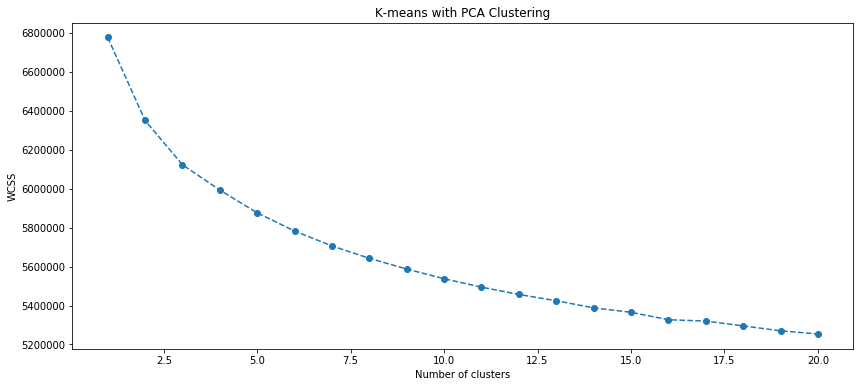

In [20]:
plt.figure(figsize=(14,6))
plt.plot(range(1,21), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [21]:
del azdias_transformed_sample

In [22]:
kmeans = KMeans(n_clusters=5)
kmodel = kmeans.fit(azdias_transformed)

In [23]:
print("Making predictions for azdias...")
azdias_clusters = kmodel.predict(azdias_transformed)
print("Making predictions for customers...")
customers_clusters = kmodel.predict(customers_transformed)

Making predictions for azdias
Making predictions for customers


In [30]:
kmodel_file = 'models/kmodel.save'
joblib.dump(kmodel, kmodel_file)

['models/kmodel.save']

In [24]:
del azdias_transformed
del customers_transformed

## Segmentation Report

In [25]:
azdias['Cluster'] = azdias_clusters
customers['Cluster'] = customers_clusters

In [26]:
azdias_proportions = Counter(azdias['Cluster'])
customers_proportions = Counter(customers['Cluster'])

In [27]:
for k, v in azdias_proportions.items():
    azdias_proportions[k] = v / len(azdias)
    
for k, v in customers_proportions.items():
    customers_proportions[k] = v / len(customers)

In [28]:
df_props = pd.DataFrame(columns=["Dataset", "Cluster", "Proportions", 'Difference'])
for k, v in customers_proportions.items():
    df_props = df_props.append({"Dataset" : "customer", "Cluster": k, "Proportions": v}, ignore_index=True)

for k, v in azdias_proportions.items():
    df_props = df_props.append({"Dataset" : "general", "Cluster": k, "Proportions": v}, ignore_index=True)

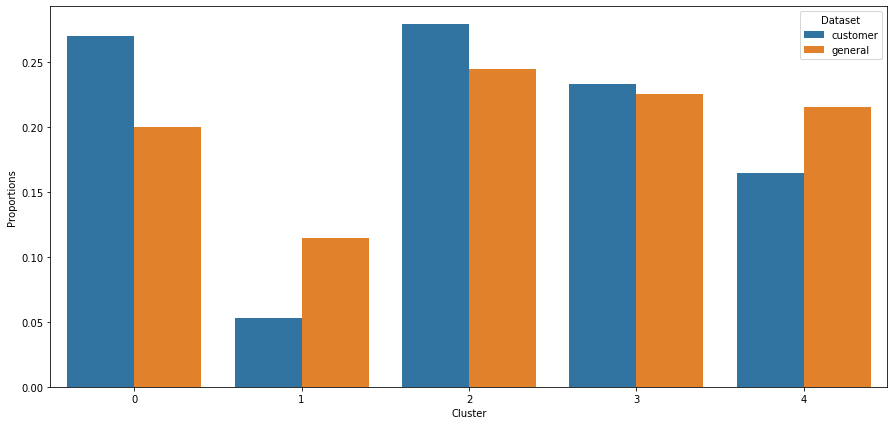

In [29]:
fig = plt.figure(figsize=(15,7))
sns.barplot(x="Cluster", y="Proportions", hue="Dataset", data=df_props);

In [37]:
cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

In [39]:
customers[cols] = customers_whole[cols]

In [43]:
# Saving data locally
data_dir = 'Data/arvato'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
azdias.to_pickle(os.path.join(data_dir, 'azdias.pkl'))
customers.to_pickle(os.path.join(data_dir, 'customers.pkl'))

In [44]:
# Uploading to S3
session.upload_data(os.path.join(data_dir, 'azdias.pkl'), key_prefix=prefix)
session.upload_data(os.path.join(data_dir, 'customers.pkl'), key_prefix=prefix)

's3://sagemaker-ap-south-1-714138043953/arvato-segmentation/customers.pkl'